# 🔬 Leukocytes images classification using Vision Transformers

***

## 📁 Set up the environment

#### Installing dependencies

In [1]:
!pip install -q wandb
!pip install -q datasets transformers
!pip install -q plotly-express

#### Importing libraries and logging

In [2]:
from huggingface_hub import notebook_login


notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [3]:
import wandb


wandb.login()

PROJECT = "vit-lcbsi-testing"
ENTITY = "polejowska"

wandb: Currently logged in as: polejowska. Use `wandb login --relogin` to force relogin


In [4]:
from datasets import load_dataset, load_metric
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer

import torch
from torchvision.transforms import (
    Compose,
    Normalize,
    Resize,
    ToTensor,
)
import numpy as np
from tqdm import tqdm

from PIL import Image
import requests

import zipfile
from io import BytesIO
import gdown
import tensorflow as tf
from tensorflow import keras

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")

## 📚 Loading the dataset



In [ ]:
run = wandb.init(project=PROJECT, entity=ENTITY, job_type="upload")

artifact = run.use_artifact('polejowska/lcbsi-wbc-monai-ai/raw_data:v0', type='dataset')

artifact_dir = artifact.download()

dataset_path = "artifacts/raw_data-v0"

run.finish()

wandb: Downloading large artifact raw_data:v0, 34.94MB. 5002 files... 
wandb:   5002 of 5002 files downloaded.  
Done. 0:0:42.9


In [5]:
from datasets import load_dataset

dataset = load_dataset("polejowska/lcbsi-wbc-ap")

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
# dataset = load_dataset("imagefolder", data_files={"train": "/content/artifacts/raw_data-v0/train/**", "test": "artifacts/raw_data-v0/test/**", "valid": "artifacts/raw_data-v0/valid/**"})

## 🔍 Explore the dataset

In [6]:
print(f"Dataset structure: {dataset}\n")
print(f"Number of training examples: {len(dataset['train'])}\n")
print(f"Dataset sample (image, label): {dataset['train'][0]}\n")
print(f"Dataset features: {dataset['train'].features}\n")
print(f"Class labels: {dataset['train'].features['label'].names}\n")

Dataset structure: DatasetDict({
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 750
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 750
    })
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3500
    })
})

Number of training examples: 3500

Dataset sample (image, label): {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F016394D460>, 'label': 0}

Dataset features: {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil'], id=None)}

Class labels: ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']



In [7]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [10]:
run = wandb.init(project=PROJECT, entity=ENTITY, job_type="upload")

wandb.config.update({"class_labels": dataset["train"].features["label"].names})
wandb.config.update({"num_train_examples": len(dataset["train"])})

#### Visualize data and display essential information

In [11]:
def plot_class_distribution(dataset, id2label, dataset_name="dataset"):
    fig = px.histogram(
        x=[id2label[label] for label in dataset["label"]],
        title=f"Distribution of classes in the {dataset_name}",
    )
    fig.update_layout(xaxis_title="Class", yaxis_title="Number of examples")
    fig.show()
    return fig

enitre_dataset_fig = plot_class_distribution(dataset["train"], id2label)
wandb.log({"class distribution in the entire dataset": enitre_dataset_fig})

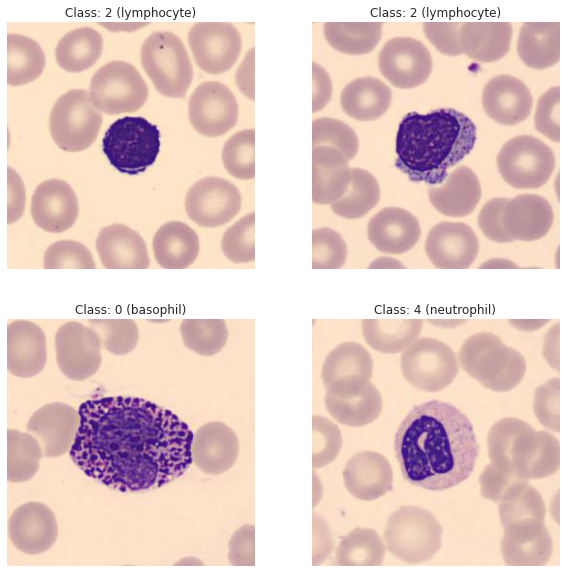

In [12]:
def display_random_images(dataset, label2id, id2label):
    # display four random images from the dataset using plotly
    fig = plt.figure(figsize=(10, 10))
    for i in range(4):
        random_image = np.random.randint(0, len(dataset))
        image = dataset[random_image]["image"]
        label = dataset[random_image]["label"]
        class_name = id2label[label]

        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(image)
        ax.set_title(f"Class: {label} ({class_name})")
        ax.axis("off")
    plt.show()
    return fig


random_images = display_random_images(dataset["train"], label2id, id2label)
wandb.log({"random_images": random_images})

***
## 🔨 Data processing

1. Resize images
2. Normalize RGB channels using mean and standard deviation

In [27]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
# model_checkpoint = "facebook/convnext-tiny-224"
# model_checkpoint = "google/vit-base-patch16-224-in21k"
# model_checkpoint = "nickmuchi/vit-base-xray-pneumonia"

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/255 [00:00<?, ?B/s]

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/preprocessor_config.json
{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [9]:
data_transforms = Compose(
        [
            Resize((224, 224)),
            ToTensor(),
            Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
        ]
    )


def add_pixel_values_feature(batch):
  batch["pixel_values"] = [
        data_transforms(image.convert("RGB")) for image in batch["image"]
  ]
  return batch


datasets_processed = dataset.rename_column('label', 'labels')

In [10]:
train_dataset = datasets_processed["train"].map(add_pixel_values_feature, batched=True)
validation_dataset = datasets_processed["valid"].map(add_pixel_values_feature, batched=True)
test_dataset = datasets_processed["test"].map(add_pixel_values_feature, batched=True)

print(f"Length of training dataset: {len(train_dataset)}")
print(f"Length of validation dataset: {len(validation_dataset)}")
print(f"Length of test dataset: {len(test_dataset)}")

Length of training dataset: 3500
Length of validation dataset: 750
Length of test dataset: 750


In [ ]:
train_dataset_fig = plot_class_distribution(train_dataset, id2label, dataset_name="training dataset")
wandb.log({"class distribution in the training dataset": train_dataset_fig})

validation_dataset_fig = plot_class_distribution(validation_dataset, id2label, dataset_name="validation dataset")
wandb.log({"class distribution in the validation dataset": validation_dataset_fig})

test_dataset_fig = plot_class_distribution(test_dataset, id2label, dataset_name="test dataset")
wandb.log({"class distribution in the test dataset": test_dataset_fig})

In [16]:
wandb.config.update({"num_train_examples": len(train_dataset)})
wandb.config.update({"num_validation_examples": len(validation_dataset)})
wandb.config.update({"num_test_examples": len(test_dataset)})

In [11]:
train_dataset.set_transform(add_pixel_values_feature)
validation_dataset.set_transform(add_pixel_values_feature)
test_dataset.set_transform(add_pixel_values_feature)

#### W&B - log dataset tables

In [ ]:
def create_table(dataset):
    table = wandb.Table(columns=["image", "label", "class name"])

    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]["image"], dataset[i]["label"]
        table.add_data(wandb.Image(image), label, id2label[label])

    return table

In [ ]:
train_table = create_table(train_dataset)
validation_table = create_table(validation_dataset)
test_table = create_table(test_dataset)

wandb.log({"train_dataset": train_table})
wandb.log({"validation_dataset": validation_table})
wandb.log({"test_dataset": test_table})

100%|██████████| 750/750 [01:42<00:00,  7.34it/s]


***
## Model configuration and training

In [12]:
def init_model():
    model = AutoModelForImageClassification.from_pretrained(
        model_checkpoint, 
        label2id=label2id,
        id2label=id2label,
        ignore_mismatched_sizes=True,
    )
    return model

In [13]:
def compute_metrics_fn(eval_preds):
  metrics = dict()
  
  accuracy_metric = load_metric('accuracy')
  precision_metric = load_metric('precision')
  recall_metric = load_metric('recall')
  f1_metric = load_metric('f1')

  logits = eval_preds.predictions
  labels = eval_preds.label_ids
  preds = np.argmax(logits, axis=-1)  
  
  metrics.update(accuracy_metric.compute(predictions=preds, references=labels))
  metrics.update(precision_metric.compute(predictions=preds, references=labels, average='weighted'))
  metrics.update(recall_metric.compute(predictions=preds, references=labels, average='weighted'))
  metrics.update(f1_metric.compute(predictions=preds, references=labels, average='weighted'))

  return metrics


In [14]:
def collate_fn(examples):
  pixel_values = torch.stack([example['pixel_values'] for example in examples])
  labels = torch.tensor([example['labels'] for example in examples])
  return {'pixel_values': pixel_values, 'labels': labels}

In [ ]:
MODEL_NAME = model_checkpoint.split("/")[-1]

In [28]:
from transformers import TrainingArguments, Trainer


def train(config=None):
  with wandb.init(config=config) as run:
    config = wandb.config

    training_args = TrainingArguments(
        output_dir='vit_train',
        report_to='wandb',
        num_train_epochs=config.epochs,
        learning_rate=config.learning_rate,
        weight_decay=config.weight_decay,
        per_device_train_batch_size=config.batch_size,
        per_device_eval_batch_size=16,
        save_strategy='epoch',
        evaluation_strategy='epoch',
        logging_strategy='epoch',
        load_best_model_at_end=True,
        remove_unused_columns=False,
        fp16=True
    )

    trainer = Trainer(
        model_init=init_model,
        args=training_args,
        data_collator=collate_fn,
        train_dataset=train_dataset,
        eval_dataset=validation_dataset,
        compute_metrics=compute_metrics_fn
    )

    trainer.train()

    trainer.evaluate()

    trainer.predict(test_dataset)

    trainer.save_state()

#### Sweep configuration

In [31]:
sweep_config = {
    'method': 'bayes'
}

metric = {
    'name': 'eval/loss',
    'goal': 'minimize'   
}

sweep_config['metric'] = metric


# hyperparameters
parameters_dict = {
    'epochs': {
        'value': 5
        },
    'batch_size': {
        'values': [8, 16, 32, 64]
        },
    'learning_rate': {
        'distribution': 'log_uniform_values',
        'min': 1e-5,
        'max': 1e-3
    },
    'weight_decay': {
        'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    },
}


sweep_config['parameters'] = parameters_dict


PROJECT = "lcbsi-vits-sweeps"
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: v1hzdxlf
Sweep URL: https://wandb.ai/polejowska/lcbsi-vits-sweeps/sweeps/v1hzdxlf


In [ ]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: dumauimq with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 1.3222768895958748e-05
wandb: 	weight_decay: 0.4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


PyTorch: setting up devices
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/config.json
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "basophil",
    "1": "eosinophil",
    "2": "lymphocyte",
    "3": "monocyte",
    "4": "neutrophil"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "basophil": 0,
    "eosinophil": 1,
    "lymphocyte": 2,
    "monocyte": 3,
    "neutrophil": 4
  },
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swin",
  "num_channels": 3,
  "num_hea

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.164200,0.629354,0.808000,0.821709,0.808000,0.804046
2,0.381800,0.227908,0.925333,0.929122,0.925333,0.925155
3,0.183100,0.132429,0.961333,0.962482,0.961333,0.961391
4,0.132500,0.099272,0.970667,0.971304,0.970667,0.970639
5,0.109000,0.096292,0.970667,0.971304,0.970667,0.970639


***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-55
Configuration saved in vit_train/checkpoint-55/config.json
Model weights saved in vit_train/checkpoint-55/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-110
Configuration saved in vit_train/checkpoint-110/config.json
Model weights saved in vit_train/checkpoint-110/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-165
Configuration saved in vit_train/checkpoint-165/config.json
Model weights saved in vit_train/checkpoint-165/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-220
Configuration saved in vit_train/checkpoint-220/config.json
Model weights saved in vit_train/checkpoint-220/pytorch_model.bin
***** Runni

***** Running Prediction *****
  Num examples = 750
  Batch size = 16


eval/accuracy,▁▆████
eval/f1,▁▆████
eval/loss,█▃▁▁▁▁
eval/precision,▁▆████
eval/recall,▁▆████
eval/runtime,▄▁█▃▂▂
eval/samples_per_second,▅█▁▆▇▇
eval/steps_per_second,▅█▁▆▇▇
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▄▄▆▆████
train/learning_rate,█▆▄▃▁


wandb: Agent Starting Run: mgdf36k3 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00025620061145057604
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


PyTorch: setting up devices
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/config.json
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "basophil",
    "1": "eosinophil",
    "2": "lymphocyte",
    "3": "monocyte",
    "4": "neutrophil"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "basophil": 0,
    "eosinophil": 1,
    "lymphocyte": 2,
    "monocyte": 3,
    "neutrophil": 4
  },
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swin",
  "num_channels": 3,
  "num_hea

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.604100,0.218635,0.925333,0.930791,0.925333,0.924973
2,0.190000,0.068528,0.978667,0.979243,0.978667,0.978641
3,0.081500,0.136383,0.972000,0.972846,0.972000,0.971852
4,0.042300,0.047586,0.992000,0.992026,0.992000,0.992004
5,0.016000,0.059575,0.992000,0.992000,0.992000,0.992000


***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-110
Configuration saved in vit_train/checkpoint-110/config.json
Model weights saved in vit_train/checkpoint-110/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-220
Configuration saved in vit_train/checkpoint-220/config.json
Model weights saved in vit_train/checkpoint-220/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-330
Configuration saved in vit_train/checkpoint-330/config.json
Model weights saved in vit_train/checkpoint-330/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-440
Configuration saved in vit_train/checkpoint-440/config.json
Model weights saved in vit_train/checkpoint-440/pytorch_model.bin
***** Ru

***** Running Prediction *****
  Num examples = 750
  Batch size = 16


eval/accuracy,▁▇▆███
eval/f1,▁▇▆███
eval/loss,█▂▅▁▁▁
eval/precision,▁▇▆███
eval/recall,▁▇▆███
eval/runtime,▆▁█▃▇▅
eval/samples_per_second,▃█▁▆▂▄
eval/steps_per_second,▃█▁▆▂▄
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▄▄▆▆████
train/learning_rate,█▆▅▃▁


wandb: Agent Starting Run: 349t74e7 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 1.0813458829979476e-05
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


PyTorch: setting up devices
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/config.json
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "basophil",
    "1": "eosinophil",
    "2": "lymphocyte",
    "3": "monocyte",
    "4": "neutrophil"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "basophil": 0,
    "eosinophil": 1,
    "lymphocyte": 2,
    "monocyte": 3,
    "neutrophil": 4
  },
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swin",
  "num_channels": 3,
  "num_hea

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.000200,0.450518,0.868000,0.875378,0.868000,0.867753
2,0.269700,0.165357,0.953333,0.954381,0.953333,0.953006
3,0.139800,0.094355,0.973333,0.974110,0.973333,0.973279
4,0.096100,0.079981,0.981333,0.981539,0.981333,0.981304
5,0.075700,0.075224,0.980000,0.980170,0.980000,0.979948


***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-110
Configuration saved in vit_train/checkpoint-110/config.json
Model weights saved in vit_train/checkpoint-110/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-220
Configuration saved in vit_train/checkpoint-220/config.json
Model weights saved in vit_train/checkpoint-220/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-330
Configuration saved in vit_train/checkpoint-330/config.json
Model weights saved in vit_train/checkpoint-330/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-440
Configuration saved in vit_train/checkpoint-440/config.json
Model weights saved in vit_train/checkpoint-440/pytorch_model.bin
***** Ru

***** Running Prediction *****
  Num examples = 750
  Batch size = 16


eval/accuracy,▁▆████
eval/f1,▁▆████
eval/loss,█▃▁▁▁▁
eval/precision,▁▆████
eval/recall,▁▆████
eval/runtime,▁▂▂▄█▄
eval/samples_per_second,█▇▇▅▁▅
eval/steps_per_second,█▇▇▅▁▅
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▄▄▆▆████
train/learning_rate,█▆▅▃▁


wandb: Agent Starting Run: vz51wchq with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0002930694611065378
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


PyTorch: setting up devices
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/config.json
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "basophil",
    "1": "eosinophil",
    "2": "lymphocyte",
    "3": "monocyte",
    "4": "neutrophil"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "basophil": 0,
    "eosinophil": 1,
    "lymphocyte": 2,
    "monocyte": 3,
    "neutrophil": 4
  },
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swin",
  "num_channels": 3,
  "num_hea

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.711000,0.151614,0.965333,0.967084,0.965333,0.965386
2,0.186100,0.104299,0.974667,0.975050,0.974667,0.974592
3,0.087000,0.103843,0.973333,0.974177,0.973333,0.973320
4,0.063200,0.079378,0.984000,0.984110,0.984000,0.983972
5,0.015000,0.063277,0.989333,0.989323,0.989333,0.989306


***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-110
Configuration saved in vit_train/checkpoint-110/config.json
Model weights saved in vit_train/checkpoint-110/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-220
Configuration saved in vit_train/checkpoint-220/config.json
Model weights saved in vit_train/checkpoint-220/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-330
Configuration saved in vit_train/checkpoint-330/config.json
Model weights saved in vit_train/checkpoint-330/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-440
Configuration saved in vit_train/checkpoint-440/config.json
Model weights saved in vit_train/checkpoint-440/pytorch_model.bin
***** Ru

***** Running Prediction *****
  Num examples = 750
  Batch size = 16


eval/accuracy,▁▄▃▆██
eval/f1,▁▄▃▆██
eval/loss,█▄▄▂▁▁
eval/precision,▁▄▃▆██
eval/recall,▁▄▃▆██
eval/runtime,▅▁▆▂█▄
eval/samples_per_second,▄█▃▇▁▅
eval/steps_per_second,▄█▂▇▁▅
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▄▄▆▆████
train/learning_rate,█▆▅▃▁


wandb: Agent Starting Run: teivjn4z with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	learning_rate: 1.2377323646536083e-05
wandb: 	weight_decay: 0.5


PyTorch: setting up devices
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/config.json
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "basophil",
    "1": "eosinophil",
    "2": "lymphocyte",
    "3": "monocyte",
    "4": "neutrophil"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "basophil": 0,
    "eosinophil": 1,
    "lymphocyte": 2,
    "monocyte": 3,
    "neutrophil": 4
  },
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swin",
  "num_channels": 3,
  "num_hea

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.556200,0.086360,0.973333,0.973537,0.973333,0.973180
2,0.133600,0.072178,0.981333,0.981536,0.981333,0.981201
3,0.079300,0.101305,0.981333,0.981694,0.981333,0.981281
4,0.059300,0.066456,0.985333,0.985521,0.985333,0.985327
5,0.038400,0.079010,0.982667,0.982928,0.982667,0.982622


***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-438
Configuration saved in vit_train/checkpoint-438/config.json
Model weights saved in vit_train/checkpoint-438/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-876
Configuration saved in vit_train/checkpoint-876/config.json
Model weights saved in vit_train/checkpoint-876/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-1314
Configuration saved in vit_train/checkpoint-1314/config.json
Model weights saved in vit_train/checkpoint-1314/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-1752
Configuration saved in vit_train/checkpoint-1752/config.json
Model weights saved in vit_train/checkpoint-1752/pytorch_model.bin
**

***** Running Prediction *****
  Num examples = 750
  Batch size = 16


## Inference using transformers pipeline

In [ ]:
def load_image_from_url(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    return image

img_url = 'https://huggingface.co/spaces/polejowska/LCBSI/resolve/main/95-8-24-1_190_1.jpg'
image = load_image_from_url(img_url)

In [ ]:
from transformers import pipeline


repo_name = "polejowska/swin-tiny-patch4-window7-224-lcbsi-wbc"
pipe = pipeline("image-classification", repo_name)

Downloading:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/388 [00:00<?, ?B/s]

In [ ]:
pipe(image)

[{'score': 0.9994284510612488, 'label': 'monocyte'},
 {'score': 0.00023444283579010516, 'label': 'eosinophil'},
 {'score': 0.00017420583753846586, 'label': 'basophil'},
 {'score': 0.00015998473099898547, 'label': 'lymphocyte'},
 {'score': 2.8791891963919625e-06, 'label': 'neutrophil'}]

In [ ]:
wandb.finish()

W&B report: https://wandb.ai/polejowska/vit-classification-lcbsi/reports/Leukocytes-classification-from-blood-smear-images--VmlldzozMTU1NjI0